<a href="https://colab.research.google.com/github/PhichamonS/Heart_Abnormality_Classification/blob/main/Model_training_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Requirement


In [1]:
!pip install -q biosppy
!pip install -q astropy
!pip install -q neurokit2
!pip install -q tensorflow
!pip install -q peakutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.0/158.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 8.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Loading data

In [ ]:
import biosppy as bp
import scipy.io.wavfile
import struct

# Set path folder
file_path = '/content/drive/MyDrive/Project/classification-of-heart-sound-recordings-the-physionet-computing-in-cardiology-challenge-2016-1.0.0/training-a/'

# Get file for the RECORDS
path_to_file = file_path + "RECORDS"
with open(path_to_file) as f:
    contents = f.readlines()
    print(contents)

# Define sampling frequency
fs = 2000
pcg_all = []
ecg_all = []
label_all = []

for i in range(0,408):
  # Get filename
  filename = contents[i][:-1]

  # ECG data: Define the binary structure format
  ecg_file = file_path + filename + '.dat'
  wav_file = file_path + filename + '.wav'

  ecg = []
  pcg = []
  try:
      # Read ECG data
      with open(ecg_file, 'rb') as file:
        binary_data = file.read()

        # Now unpack all data at once
        data = struct.iter_unpack('h', binary_data)
        for item in data:
          ecg.append(item[0])

      # Read PCG data
      fs, pcg = scipy.io.wavfile.read(wav_file)

      # Get same lenght of signal
      if (len(pcg)>= 40000 and len(ecg)>= 40000) :
        pcg = pcg[5000:40000]
        ecg = ecg[5000:40000]

        # Read classification label
        with open(file_path + filename + '.hea') as f:
            data_info = f.readlines()
            label = 0 if data_info[-1][2:-1] == 'Normal' else 1

        pcg_all.append(pcg)
        ecg_all.append(ecg)
        label_all.append(label)
      else:
        continue

  except:
      continue

n = np.shape(np.array(pcg_all))[1]
timevec = np.arange(0, n) / fs

['a0001\n', 'a0002\n', 'a0003\n', 'a0004\n', 'a0005\n', 'a0006\n', 'a0007\n', 'a0008\n', 'a0009\n', 'a0010\n', 'a0011\n', 'a0012\n', 'a0013\n', 'a0014\n', 'a0015\n', 'a0016\n', 'a0017\n', 'a0018\n', 'a0019\n', 'a0020\n', 'a0021\n', 'a0022\n', 'a0023\n', 'a0024\n', 'a0025\n', 'a0026\n', 'a0027\n', 'a0028\n', 'a0029\n', 'a0030\n', 'a0031\n', 'a0032\n', 'a0033\n', 'a0034\n', 'a0035\n', 'a0036\n', 'a0037\n', 'a0038\n', 'a0039\n', 'a0040\n', 'a0042\n', 'a0043\n', 'a0044\n', 'a0045\n', 'a0046\n', 'a0047\n', 'a0048\n', 'a0049\n', 'a0050\n', 'a0051\n', 'a0052\n', 'a0053\n', 'a0054\n', 'a0055\n', 'a0056\n', 'a0057\n', 'a0058\n', 'a0059\n', 'a0060\n', 'a0061\n', 'a0062\n', 'a0063\n', 'a0064\n', 'a0065\n', 'a0066\n', 'a0067\n', 'a0068\n', 'a0069\n', 'a0070\n', 'a0071\n', 'a0072\n', 'a0073\n', 'a0074\n', 'a0075\n', 'a0076\n', 'a0077\n', 'a0078\n', 'a0079\n', 'a0080\n', 'a0081\n', 'a0082\n', 'a0083\n', 'a0084\n', 'a0085\n', 'a0086\n', 'a0087\n', 'a0088\n', 'a0089\n', 'a0090\n', 'a0091\n', 'a0092\n'

In [ ]:
np.save('/content/drive/MyDrive/Project/processed_data/ecg_all.npy', ecg_all)
np.save('/content/drive/MyDrive/Project/processed_data/pcg_all.npy', pcg_all)
np.save('/content/drive/MyDrive/Project/processed_data/label_all.npy', label_all)

# 3. Data processing

In [ ]:
ecg_all = np.load('/content/drive/MyDrive/Project/processed_data/ecg_all.npy', allow_pickle=True)
pcg_all = np.load('/content/drive/MyDrive/Project/processed_data/pcg_all.npy', allow_pickle=True)
label_all =  np.load('/content/drive/MyDrive/Project/processed_data/label_all.npy', allow_pickle=True)

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 25 12:24:36 2023

@author: sofia
"""

import numpy as np
import biosppy
from scipy.signal import resample_poly, resample, hilbert, butter, filtfilt,stft
from matplotlib.mlab import specgram
from pywt import downcoef

def get_envelope_features(signal,fs):

    # Filter Design
    order = 2
    passBand = np.array([25, 400])

    # Band-Pass filtering of the PCG:
    filtered,fs,params = biosppy.signals.tools.filter_signal(signal,'butter','bandpass',order,passBand,fs)

    # spike removal
    filtered = spike_removal(np.transpose(filtered),fs)
    filtered = resample(filtered,int((1000/fs)*len(filtered)))

    # homomorphic envelope
    fs = 1000
    e1 = homomorphic_envelope(filtered,fs)
    downs_e1 = resample_poly(e1,1,fs/50)
    downs_e1, = biosppy.signals.tools.normalize(downs_e1)
    downs_e1[0] = downs_e1[1]

    # hilbert envelope
    e2 = hilbert_envelope(filtered)
    downs_e2 = resample_poly(e2,1,fs/50)
    downs_e2, = biosppy.signals.tools.normalize(downs_e2)
    downs_e2[0] = downs_e2[1]

    # power spectral density envelope
    e3 = psd_envelope(filtered, fs)
    downs_e3 = resample(e3,len(downs_e1))
    downs_e3, = biosppy.signals.tools.normalize(downs_e3)
    downs_e3[0] = downs_e3[1]

    # wavelet envelope
    e4 = wavelet_envelope(filtered)
    e4 = e4[:len(e1)]
    downs_e4 = resample_poly(e4,1,fs/50)
    downs_e4, = biosppy.signals.tools.normalize(downs_e4)
    downs_e4[0] = downs_e4[1]

    envelopes = np.zeros((len(downs_e1),4))
    envelopes[:,0] = downs_e1
    envelopes[:,1] = downs_e2
    envelopes[:,2] = downs_e3
    envelopes[:,3] = downs_e4

    return envelopes

def homomorphic_envelope(x, fs=1000, f_LPF=8, order=1):

    b, a = butter(order, 2 * f_LPF / fs, 'low')
    he = np.exp(filtfilt(b, a, np.log(np.abs(hilbert(x)))))

    # Remove spurious spikes in first sample:
    he[0] = he[1]

    return he

def hilbert_envelope(x):

    he = np.abs(hilbert(x))

    return he

def psd_envelope(x, fs):

    spectrum,frequencies,t = specgram(x,NFFT=int(fs/40),Fs=fs,window=np.hamming(fs/40),noverlap=int(fs/80),mode='psd');

    low_limit_position = np.argwhere(frequencies==40)[0][0]
    high_limit_position = np.argwhere(frequencies==80)[0][0]
    psd = np.mean(spectrum[low_limit_position:high_limit_position+1,:],axis=0);

    return psd

def wavelet_envelope(x):

    coeffs = downcoef('d',x, 'rbio3.9', level=3)
    coeffs = np.repeat(coeffs,2**3)

    d = (len(coeffs) - len(x))/2
    first =  int(np.floor(d))
    last = int(len(coeffs) - np.ceil(d))

    coeffs = coeffs[first:last]
    wavelet_feature = abs(coeffs)

    return wavelet_feature

def spike_removal(signal,fs):

    window_size = round(fs/2)
    trailing_samples = len(signal)%window_size


    if trailing_samples >  0:
        sampleframes = np.reshape(signal[:-trailing_samples],(window_size,int(len(signal[:-trailing_samples])/window_size)))
    else:
        sampleframes = np.reshape(signal,(window_size,int(len(signal)/window_size)))


    MAAs = np.amax(abs(sampleframes),axis=0);

    while len(np.argwhere(MAAs>np.median(MAAs)*3)) > 0:

        window_num = np.argmax(MAAs)

        if np.size(window_num)>1:
            window_num = window_num[0]

        spike_position = np.argmax(abs(sampleframes[:,window_num]));

        if np.size(spike_position)>1:
            spike_position = spike_position[0]


        zero_crossings = np.concatenate((abs(np.diff(np.sign(sampleframes[:,window_num])))>1,np.array([False])),axis=0)
        try:
            spike_start = max(np.concatenate((np.array([0]), np.argwhere(zero_crossings[0:spike_position+1]==1)[-1])))
        except:
            spike_start = 0

        zero_crossings[0:spike_position+1] = 0

        try:
            spike_end = min(np.concatenate((np.argwhere(zero_crossings==1)[0], np.array([window_size-1]))))
        except:
            spike_end = window_size -1

        sampleframes[spike_start:(spike_end+1),window_num] = 0.0001;

        MAAs = np.amax(abs(sampleframes),axis=0);

    despiked_signal = np.reshape(sampleframes, (np.size(sampleframes),1));
    despiked_signal = np.concatenate((despiked_signal.ravel(),signal[len(despiked_signal):]),axis=0);

    return despiked_signal


def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def downsample_signal(signal, original_fs, target_fs, axis = 0):
    # Calculate the number of samples in the downsampled signal
    num_samples = int(len(signal) * target_fs / original_fs)

    # Resample the signal
    downsampled_signal = resample(signal, num_samples, axis = axis)

    return downsampled_signal

def get_instanteneous_frequency(signal,fs):

  analytic_signal = hilbert(signal)
  amplitude_envelope = np.abs(analytic_signal)
  instantaneous_phase = np.unwrap(np.angle(analytic_signal))
  instantaneous_frequency = np.insert((np.diff(instantaneous_phase) /(2.0*np.pi) * fs),0,0)
  instantaneous_frequency, = biosppy.signals.tools.normalize(instantaneous_frequency)

  return instantaneous_frequency

def pre_process_ECG(signal,fs):
  bandpass = np.array([0.5, 100])
  # filter signal with bandpass
  signal,fs,params = biosppy.signals.tools.filter_signal(signal,'butter','bandpass',2, bandpass, fs)

  # downsample signal
  fs_downsamp = 50
  signal_downasmp = downsample_signal(signal,fs,fs_downsamp)

  # Get time-freq signal
  instantaneous_frequency = get_instanteneous_frequency(signal_downasmp,fs_downsamp)

  # norm signal
  signal_norm, = biosppy.signals.tools.normalize(signal_downasmp)

  process_ECG = np.zeros((len(signal_norm),2))
  process_ECG[:,0] = signal_norm
  process_ECG[:,1] = instantaneous_frequency

  return process_ECG



In [ ]:
from scipy import signal
import biosppy as bp

scaler = MinMaxScaler()

# Initialize lists to store processed signals
X_pcg = []
X_ecg = []

fs =2000
# Loop through the signals
for i in range(len(pcg_all)):
    # Process PCG
    # pcg_temp = butter_bandpass_filter(pcg_all[i], lowcut=20, highcut=450, fs=fs, order=2)
    # pcg_temp = bp.signals.pcg.homomorphic_filter(signal=pcg_all[i], sampling_rate=fs, f_LPF=8, order=2)[0]
    # pcg_temp = scaler.fit_transform(pcg_temp.reshape(-1,1)).flatten()
    # pcg_temp = nk.standardize(pcg_temp)
    pcg_temp = get_envelope_features(signal=pcg_all[i], fs=fs)
    X_pcg.append(pcg_temp)

    # Process ECG
    # ecg_temp = butter_bandpass_filter(ecg_all[i], lowcut=0.5, highcut=50, fs=fs, order=2)
    # ecg_temp = scaler.fit_transform(ecg_temp.reshape(-1,1)).flatten()
    # ecg_temp = nk.standardize(ecg_temp)
    ecg_temp = pre_process_ECG(signal =ecg_all[i], fs=fs)
    X_ecg.append(ecg_temp)

# Convert lists to numpy arrays
X_pcg = np.array(X_pcg)
X_ecg = np.array(X_ecg)
y = np.array(label_all)

In [ ]:
X_ecg.shape

(398, 875, 2)

In [ ]:
X_pcg.shape

(398, 875, 4)

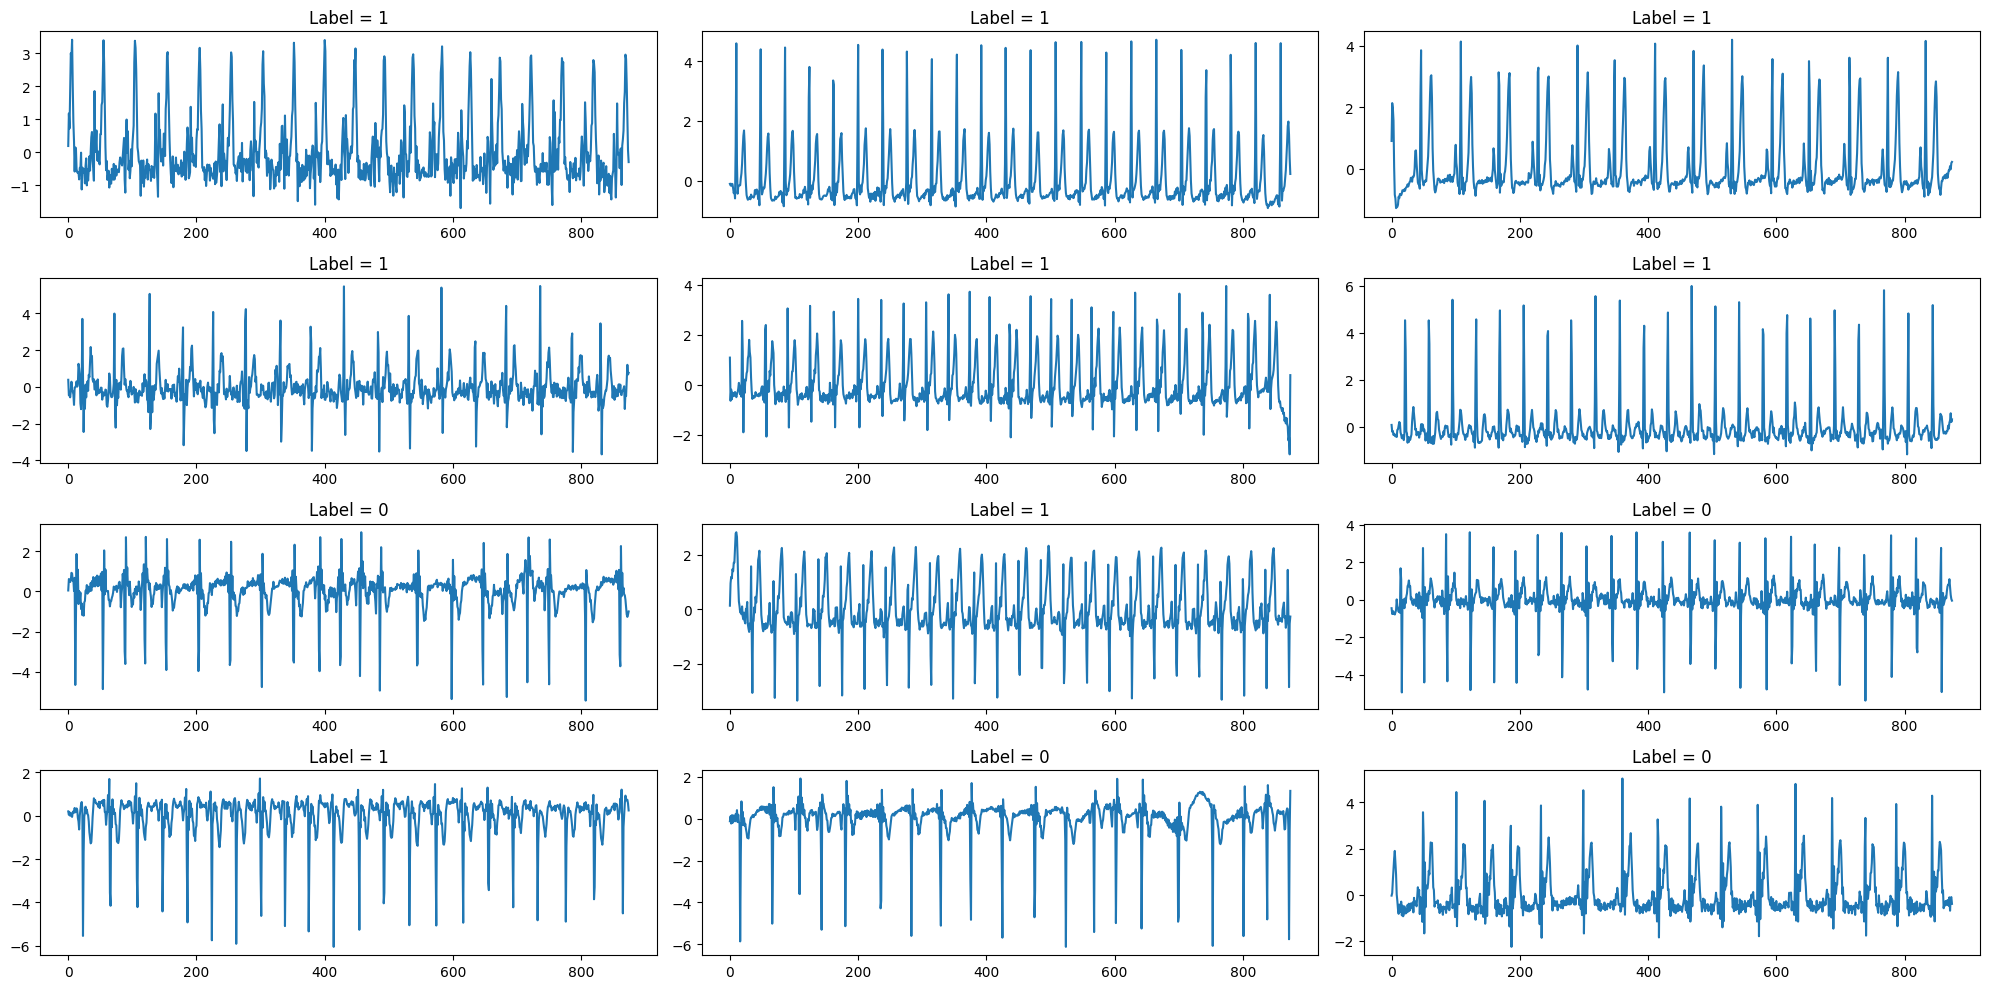

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots (adjust according to the number of plots needed)
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()

# Plot in each subplot
for idx, i in enumerate(range(0,12)):

    ecg_temp,fs,params = biosppy.signals.tools.filter_signal(ecg_all[i],'butter','bandpass',2,np.array([0.5, 100]), 2000)
    ecg_temp = downsample_signal(ecg_temp, 2000, 50)
    ecg_temp, = biosppy.signals.tools.normalize(ecg_temp)
    axs[idx].plot(ecg_temp)
    axs[idx].set_title('Label = ' + str(label_all[i]))  # Set the title

# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()

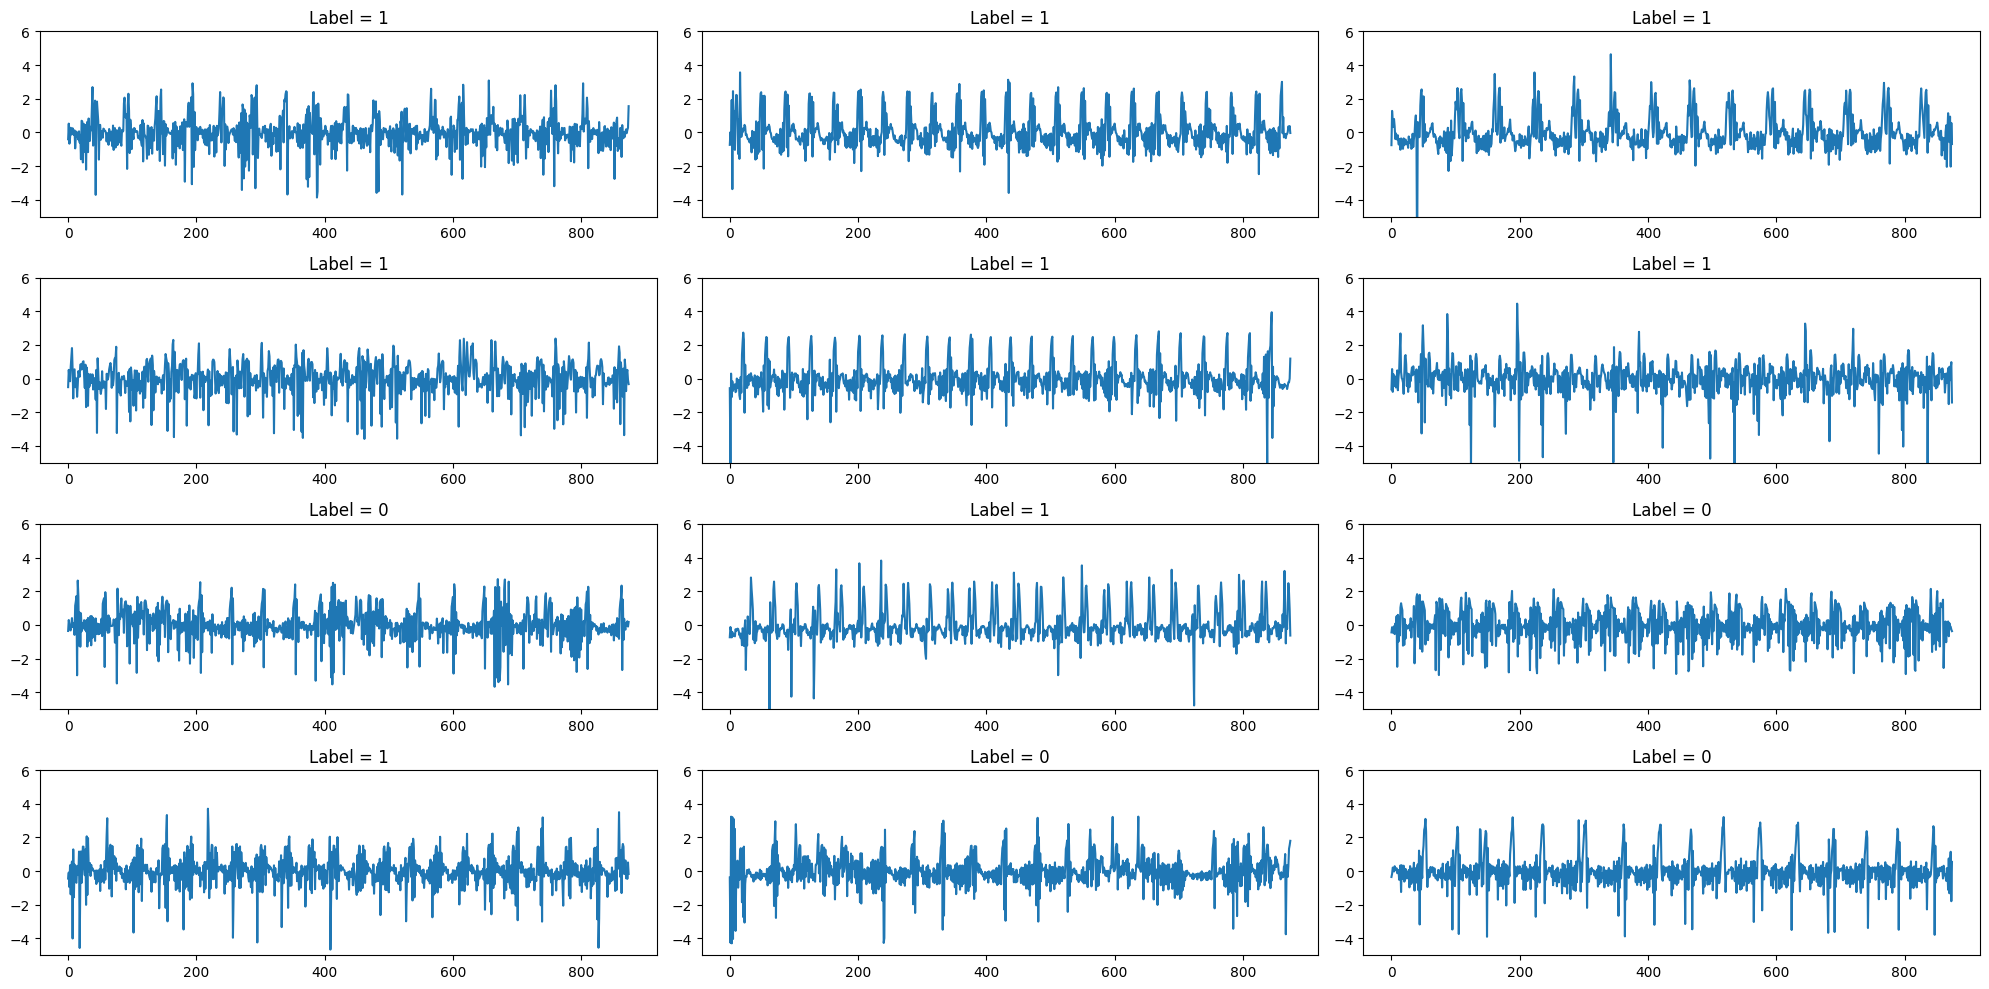

In [ ]:
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots (adjust according to the number of plots needed)
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()
y_limit = (-5,6)

# Plot in each subplot
for idx, i in enumerate(range(0,12)):
    ecg_temp,fs,params = biosppy.signals.tools.filter_signal(ecg_all[i],'butter','bandpass',2,np.array([0.5, 100]), 2000)
    ecg_temp = downsample_signal(ecg_temp,2000,50)
    analytic_signal = hilbert(ecg_temp)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = np.insert((np.diff(instantaneous_phase) /
                              (2.0*np.pi) * 50),0,0)


    instantaneous_frequency, = biosppy.signals.tools.normalize(instantaneous_frequency)

    axs[idx].plot(instantaneous_frequency)
    axs[idx].set_title('Label = ' + str(label_all[i]))  # Set the title
    axs[idx].set_ylim(y_limit)

# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Project/processed_data/ecg_processed_2.npy', X_ecg)
np.save('/content/drive/MyDrive/Project/processed_data/pcg_processed_2.npy', X_pcg)

# 4. Preparing input

### 4.0 Load data from save file

In [ ]:
X_ecg = np.load('/content/drive/MyDrive/Project/processed_data/ecg_processed_2.npy', allow_pickle=True)
X_pcg = np.load('/content/drive/MyDrive/Project/processed_data/pcg_processed_2.npy', allow_pickle=True)
y = np.load('/content/drive/MyDrive/Project/processed_data/label_all.npy', allow_pickle=True)


### 4.1 Train-Test split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Stack along the last axis
X_combined = np.concatenate((X_ecg, X_pcg), axis=2)
# y =  to_categorical(y, num_classes = 2)
try:
  y = y.reshape(-1,1)
except:
  y = np.array(y).reshape(-1,1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)



In [ ]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))
print(np.sum(y_test==0))
print(np.sum(y_test==1))

95
223
20
60


### 4.2 Segmentation: slice into smaller window

In [ ]:
# Function to segment a single signal
def segment_signal(signal, segment_length=2000, overlap=0):
    """
    Segment a signal into smaller chunks of `segment_length`.

    Parameters:
    - signal: The input time-series signal (e.g., ECG or PCG) to be segmented.
    - segment_length: Length of each segment (default = 2000).
    - overlap: Number of overlapping samples between segments (default = 0).

    Returns:
    - List of segmented signals.
    """
    segments = []
    step = segment_length - overlap

    # Create segments from the signal
    for start in range(0, len(signal) - segment_length + 1, step):
        segment = signal[start:start + segment_length]
        segments.append(segment)

    return segments

# Segment the entire list of signals (both ECG and PCG)
def segment_data(signals, segment_length=2000, overlap=0):
    """
    Apply segmentation to a list of signals.

    Parameters:
    - signals: List of time-series signals (e.g., X_ecg or X_pcg).
    - segment_length: Length of each segment (default = 2000).
    - overlap: Number of overlapping samples between segments (default = 0).

    Returns:
    - List of segmented signals.
    """
    segmented_data = []

    for signal in signals:
        # Segment each signal in the list
        segmented_data.extend(segment_signal(signal, segment_length, overlap))

    return segmented_data


# Segment ECG and PCG signals
segment_length = 200 # (for 50 Hz -> 4 sec)

X_train_segmented = []
y_train_segmented = []
for i in range(0,len(X_train)):
  if y_train[i] == 0:
    overlap = 160
  else:
    overlap = 100
  X_train_segmented.extend(segment_signal(X_train[i], segment_length, overlap=overlap))
  y_train_segmented.extend([y_train[i]] * len(segment_signal(X_train[i], segment_length, overlap=overlap)))

X_test_segmented = []
y_test_segmented = []
for i in range(0,len(X_test)):
  if y_test[i] == 0:
    overlap = 160
  else:
    overlap = 80
  X_test_segmented.extend(segment_signal(X_test[i], segment_length, overlap=overlap))
  y_test_segmented.extend([y_test[i]] * len(segment_signal(X_test[i], segment_length, overlap=overlap)))

# Convert the segmented data to NumPy arrays for training
X_train_segmented = np.array(X_train_segmented)
X_test_segmented = np.array(X_test_segmented)
y_train_segmented = np.array(y_train_segmented)
y_test_segmented = np.array(y_test_segmented)

# Check the shapes of segmented data
print("X_train_segmented shape:", X_train_segmented.shape)
print("X_test_segmented shape:", X_test_segmented.shape)
print("y_train shape:", y_train_segmented.shape)
print("y_test shape:", y_test_segmented.shape)


X_train_segmented shape: (3176, 200, 6)
X_test_segmented shape: (700, 200, 6)
y_train shape: (3176, 1)
y_test shape: (700, 1)


In [ ]:
print(np.sum(y_test_segmented==0))
print(np.sum(y_test_segmented==1))
print(np.sum(y_train_segmented==0))
print(np.sum(y_train_segmented==1))

340
360
1615
1561


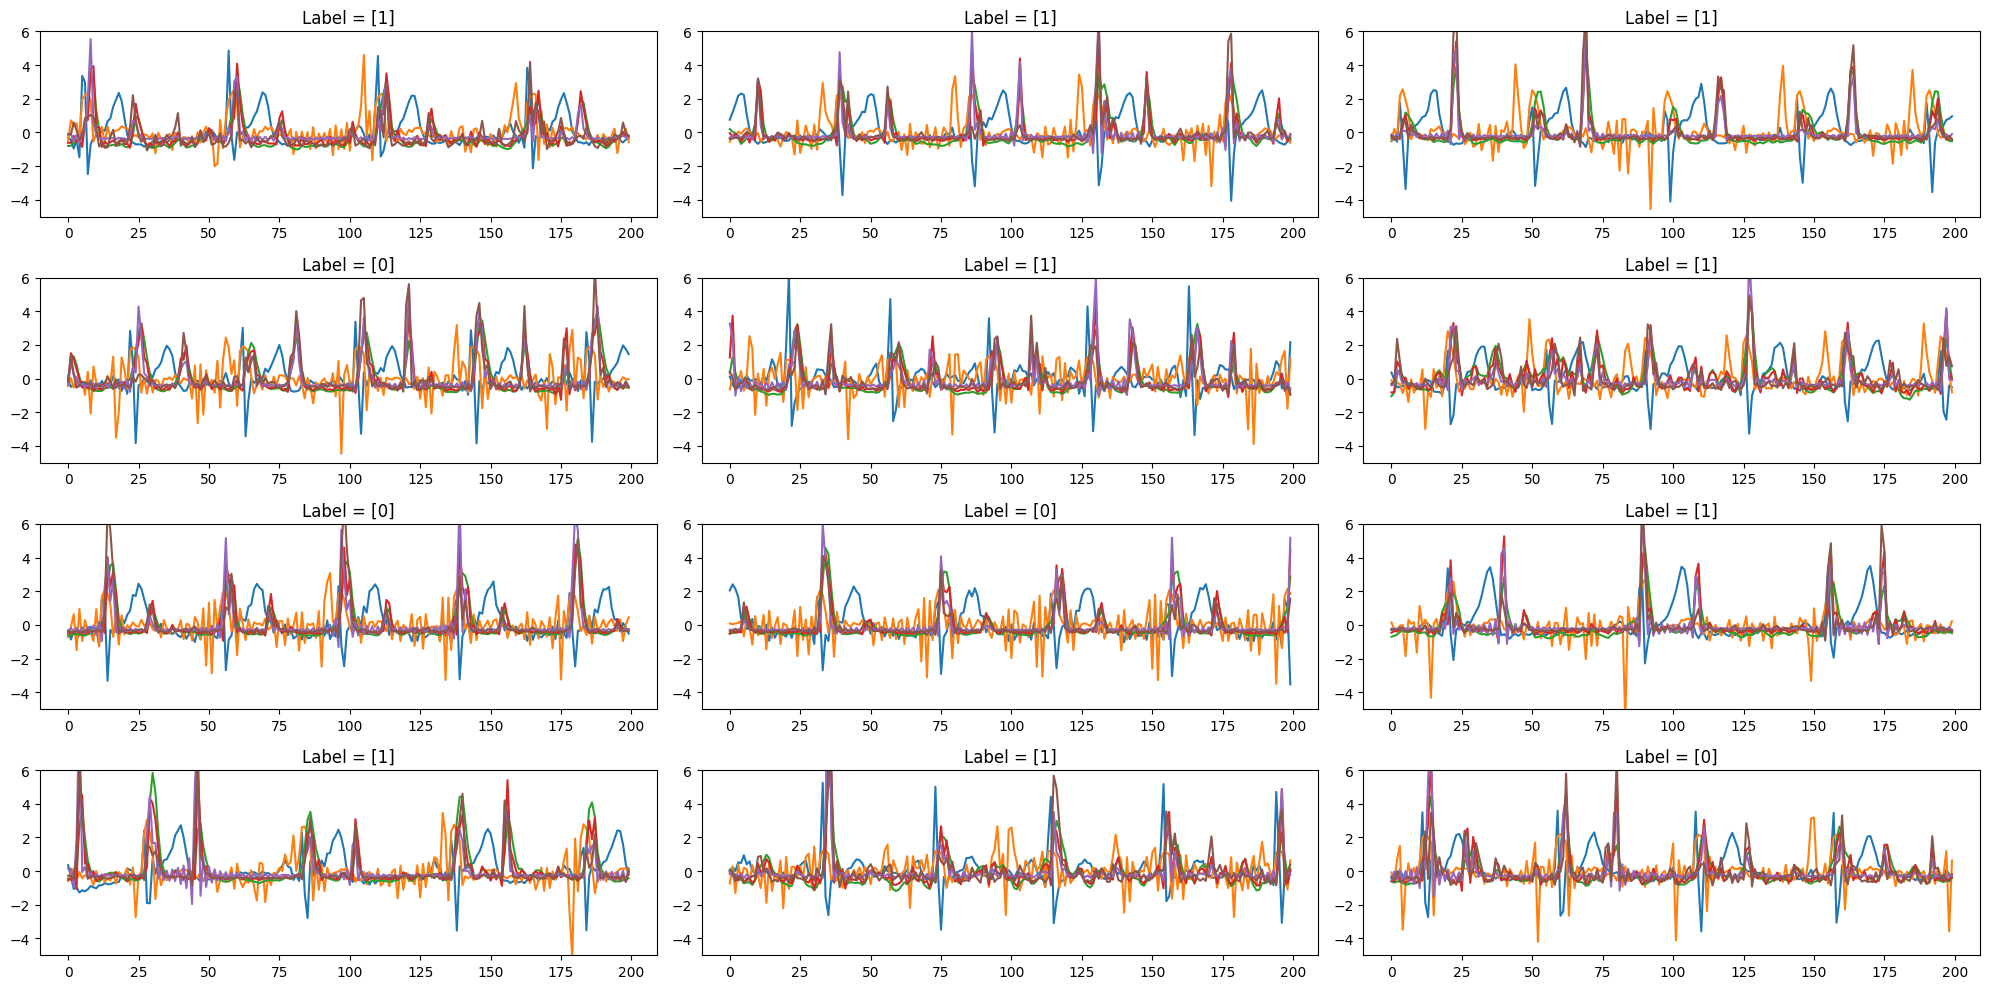

In [ ]:
import matplotlib.pyplot as plt

# Create grid of subplots
fig, axs = plt.subplots(4, 3, figsize=(20, 10))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()
y_limit = (-5,6)
# Plot in each subplot
for idx, i in enumerate(range(200, 320, 10)):
    axs[idx].plot(X_train_segmented[i])
    axs[idx].set_title('Label = ' + str(y_train_segmented[i]))  # Set the title
    axs[idx].set_ylim(y_limit)


# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()


label = [0]


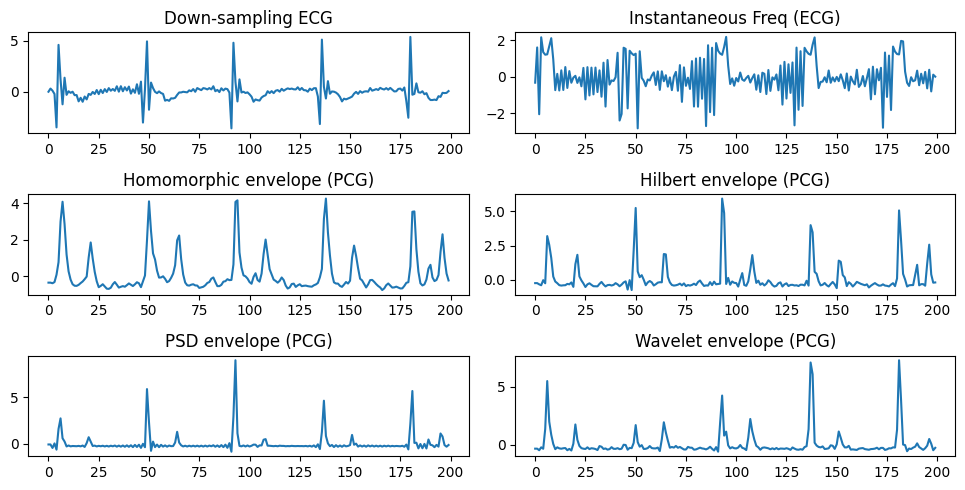

In [ ]:
import matplotlib.pyplot as plt

# Create grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()
feat_name = ["Down-sampling ECG",
             "Instantaneous Freq (ECG)",
             "Homomorphic envelope (PCG)",
             "Hilbert envelope (PCG)",
             "PSD envelope (PCG)",
             "Wavelet envelope (PCG)"]
i= 7 #400
print("label = " + str(y_train_segmented[i]))
# Plot in each subplot
for k in range(0,6):
  axs[k].plot(X_train_segmented[i,:,k])
  axs[k].set_title(feat_name[k])  # Set the title

# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()

label = [1]


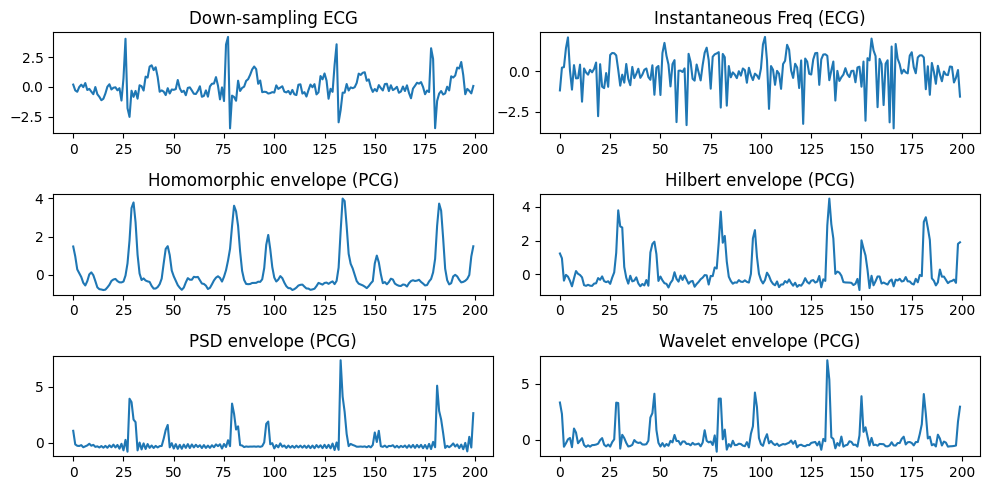

In [ ]:
import matplotlib.pyplot as plt

# Create grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Flatten the axes array so we can index it in a single loop
axs = axs.flatten()
feat_name = ["Down-sampling ECG",
             "Instantaneous Freq (ECG)",
             "Homomorphic envelope (PCG)",
             "Hilbert envelope (PCG)",
             "PSD envelope (PCG)",
             "Wavelet envelope (PCG)"]
i= 2 #300
print("label = " + str(y_train_segmented[i]))
# Plot in each subplot
for k in range(0,6):
  axs[k].plot(X_train_segmented[i,:,k])
  axs[k].set_title(feat_name[k])  # Set the title

# Adjust the layout so titles and plots don't overlap
plt.tight_layout()
plt.show()

# 5. Model training


### Training 1: LSTM - one direction

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# undersampling of class 0
# bidiectional LSTM to get forward and backward

# Define LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_segmented.shape[1], X_train_segmented.shape[2]), return_sequences=True))  # Add LSTM layer
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=8e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200, 64)             │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,313 (489.50 KB)

 Trainable params: 125,313 (489.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# class_weight = {0: 3.0, 1: 1.0}

# Train the model
history = model.fit(X_train_segmented, y_train_segmented,
                    epochs=50,
                    batch_size=200,
                    validation_data=(X_test_segmented, y_test_segmented),
                    callbacks=[early_stopping, reduce_lr],
                    # class_weight=class_weight,
                    shuffle=True)

# Saving the model
model.save('LSTM_ECG_PCG.keras')

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5080 - loss: 1.4940 - val_accuracy: 0.5243 - val_loss: 1.3668 - learning_rate: 8.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5722 - loss: 1.3268 - val_accuracy: 0.5586 - val_loss: 1.2201 - learning_rate: 8.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5827 - loss: 1.1839 - val_accuracy: 0.6086 - val_loss: 1.0859 - learning_rate: 8.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6322 - loss: 1.0571 - val_accuracy: 0.6300 - val_loss: 0.9976 - learning_rate: 8.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6413 - loss: 0.9593 - val_accuracy: 0.6686 - val_loss: 0.9123 - learning_rate: 8.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6538 - loss: 0.8870 - val_accuracy: 0.6457 - val_loss: 0.8403 - learning_rate: 8.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6928 - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.7634 - loss: 0.6352
Test accuracy: 0.7771428823471069


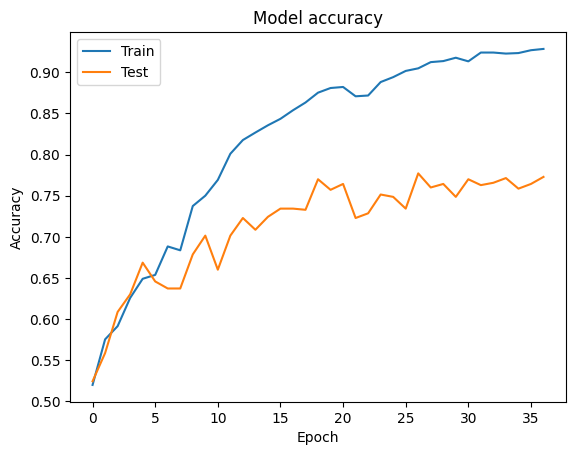

In [ ]:
import matplotlib.pyplot as plt
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_segmented, y_test_segmented)
print(f"Test accuracy: {test_acc}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step


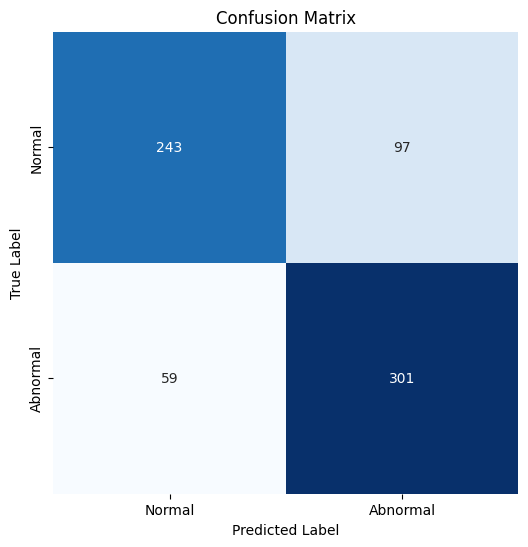

              precision    recall  f1-score   support

      Normal       0.80      0.71      0.76       340
    Abnormal       0.76      0.84      0.79       360

    accuracy                           0.78       700
   macro avg       0.78      0.78      0.78       700
weighted avg       0.78      0.78      0.78       700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict
y_pred = (model.predict(X_test_segmented) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test_segmented, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_segmented, y_pred, target_names=['Normal', 'Abnormal']))

### Training 2.1: LSTM - bidirectional (ECG and PCG)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_segmented.shape[1], X_train_segmented.shape[2]), return_sequences=True)))  # Add LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=8e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# class_weight = {0: 3.0, 1: 1.0}

# Train the model
history = model.fit(X_train_segmented, y_train_segmented,
                    epochs=50,
                    batch_size=200,
                    validation_data=(X_test_segmented, y_test_segmented),
                    callbacks=[early_stopping, reduce_lr],
                    # class_weight=class_weight,
                    shuffle=True)

# Saving the model
model.save('LSTM_bidirectional_ECG_PCG.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5190 - loss: 1.6584 - val_accuracy: 0.5071 - val_loss: 1.4671 - learning_rate: 8.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5501 - loss: 1.4084 - val_accuracy: 0.5600 - val_loss: 1.2559 - learning_rate: 8.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6129 - loss: 1.2034 - val_accuracy: 0.6486 - val_loss: 1.0712 - learning_rate: 8.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6290 - loss: 1.0385 - val_accuracy: 0.5871 - val_loss: 0.9899 - learning_rate: 8.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6119 - loss: 0.9515 - val_accuracy: 0.6214 - val_loss: 0.8903 - learning_rate: 8.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6629 - loss: 0.8349 - val_accuracy: 0.6543 - val_loss: 0.8033 - learning_rate: 8.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6954 - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step - accuracy: 0.7642 - loss: 0.5144
Test accuracy: 0.7471428513526917 , Test lost: 0.55887770652771


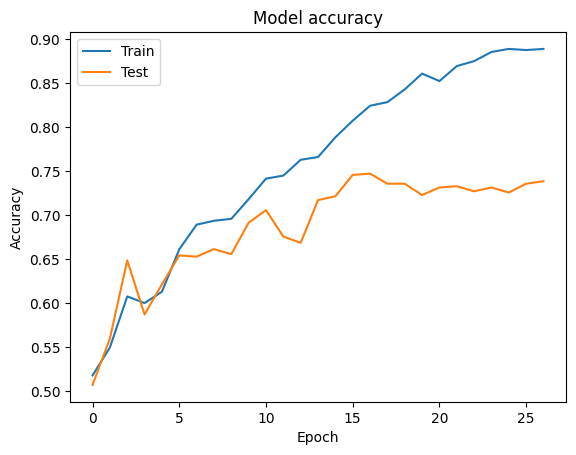

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_segmented, y_test_segmented)
print(f"Test accuracy: {test_acc} , Test lost: {test_loss}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step


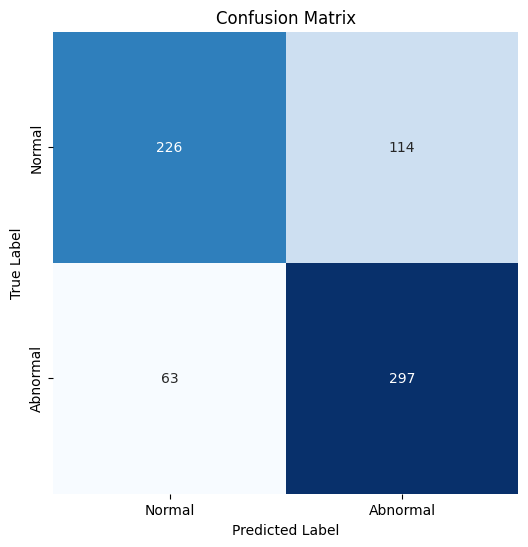

              precision    recall  f1-score   support

      Normal       0.78      0.66      0.72       340
    Abnormal       0.72      0.82      0.77       360

    accuracy                           0.75       700
   macro avg       0.75      0.74      0.74       700
weighted avg       0.75      0.75      0.75       700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict
y_pred = (model.predict(X_test_segmented) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test_segmented, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_segmented, y_pred, target_names=['Normal', 'Abnormal']))


### Traning 2.2: LSTM - bidirectional (Only ECG)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_segmented.shape[1], 1), return_sequences=True)))  # Add LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=8e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# class_weight = {0: 3.0, 1: 1.0}

# Train the model
history = model.fit(X_train_segmented[:,:,0:2], y_train_segmented,
                    epochs=50,
                    batch_size=200,
                    validation_data=(X_test_segmented[:,:,0:2], y_test_segmented),
                    callbacks=[early_stopping, reduce_lr],
                    # class_weight=class_weight,
                    shuffle=True)

# Saving the model
model.save('LSTM_bidirectional_ECG.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.5016 - loss: 1.6507 - val_accuracy: 0.5229 - val_loss: 1.4578 - learning_rate: 8.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5520 - loss: 1.4025 - val_accuracy: 0.5743 - val_loss: 1.2489 - learning_rate: 8.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5643 - loss: 1.2084 - val_accuracy: 0.6529 - val_loss: 1.0678 - learning_rate: 8.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5974 - loss: 1.0474 - val_accuracy: 0.5971 - val_loss: 0.9793 - learning_rate: 8.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6238 - loss: 0.9331 - val_accuracy: 0.5829 - val_loss: 0.8887 - learning_rate: 8.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.6618 - loss: 0.8269 - val_accuracy: 0.5971 - val_loss: 0.8400 - learning_rate: 8.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.6654 - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 204ms/step - accuracy: 0.6702 - loss: 0.7667
Test accuracy: 0.668571412563324 , Test lost: 0.7598978281021118


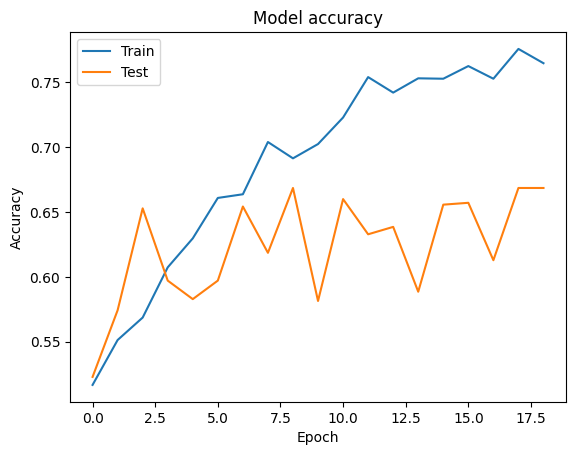

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_segmented[:,:,0:2], y_test_segmented)
print(f"Test accuracy: {test_acc} , Test lost: {test_loss}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step


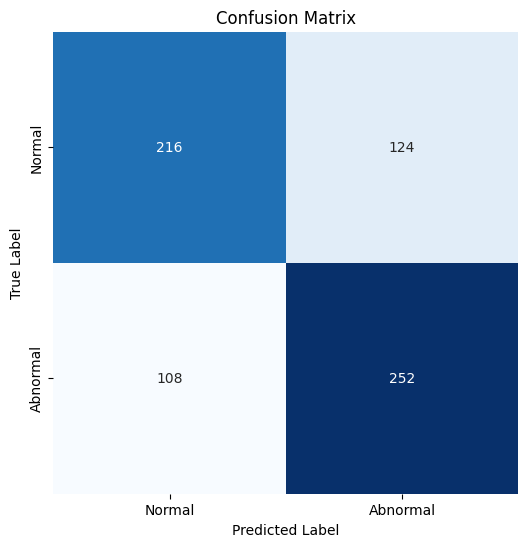

              precision    recall  f1-score   support

      Normal       0.67      0.64      0.65       340
    Abnormal       0.67      0.70      0.68       360

    accuracy                           0.67       700
   macro avg       0.67      0.67      0.67       700
weighted avg       0.67      0.67      0.67       700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict
y_pred = (model.predict(X_test_segmented[:,:,0:2]) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test_segmented, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_segmented, y_pred, target_names=['Normal', 'Abnormal']))


### Training 2.3: LSTM - bidirectional (Only PCG)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(64, input_shape=(X_train_segmented.shape[1], 4), return_sequences=True)))  # Add LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.2))  # Add dropout to prevent overfitting
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=8e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
# class_weight = {0: 3.0, 1: 1.0}

# Train the model
history = model.fit(X_train_segmented[:,:,2:6], y_train_segmented,
                    epochs=50,
                    batch_size=200,
                    validation_data=(X_test_segmented[:,:,2:6], y_test_segmented),
                    callbacks=[early_stopping, reduce_lr],
                    # class_weight=class_weight,
                    shuffle=True)
# Saving the model
model.save('LSTM_bidirectional_PCG.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.4975 - loss: 1.6508 - val_accuracy: 0.5143 - val_loss: 1.4597 - learning_rate: 8.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5440 - loss: 1.4035 - val_accuracy: 0.5229 - val_loss: 1.2576 - learning_rate: 8.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5339 - loss: 1.2119 - val_accuracy: 0.5500 - val_loss: 1.0992 - learning_rate: 8.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5668 - loss: 1.0600 - val_accuracy: 0.6057 - val_loss: 0.9736 - learning_rate: 8.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5838 - loss: 0.9478 - val_accuracy: 0.5043 - val_loss: 0.9294 - learning_rate: 8.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5226 - loss: 0.8960 - val_accuracy: 0.5771 - val_loss: 0.8405 - learning_rate: 8.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5554 - loss:

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 203ms/step - accuracy: 0.6457 - loss: 0.6249
Test accuracy: 0.6442857384681702 , Test lost: 0.6339176893234253


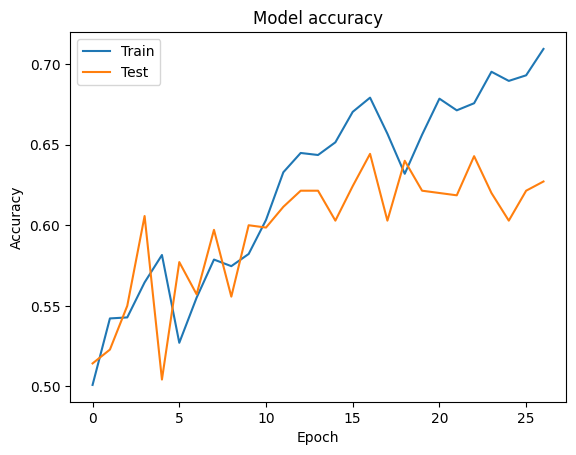

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_segmented[:,:,2:6], y_test_segmented)
print(f"Test accuracy: {test_acc} , Test lost: {test_loss}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step


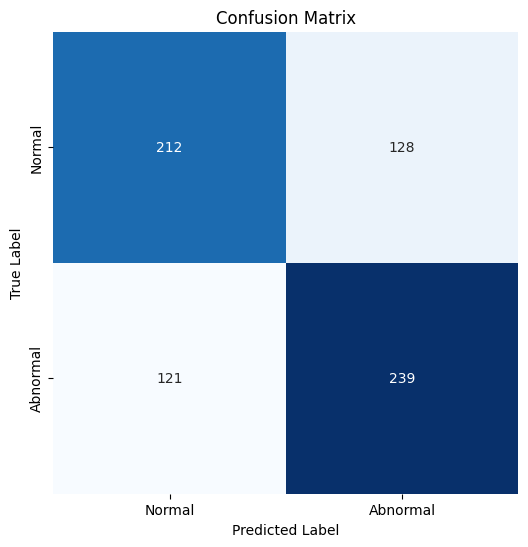

              precision    recall  f1-score   support

      Normal       0.64      0.62      0.63       340
    Abnormal       0.65      0.66      0.66       360

    accuracy                           0.64       700
   macro avg       0.64      0.64      0.64       700
weighted avg       0.64      0.64      0.64       700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict
y_pred = (model.predict(X_test_segmented[:,:,2:6]) > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test_segmented, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test_segmented, y_pred, target_names=['Normal', 'Abnormal']))


### Training 3: Modify achitecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Build the LSTM model
def build_lstm_model(timesteps, features_ecg, features_pcg):
    # ECG input branch
    input_ecg = Input(shape=(timesteps, features_ecg))
    lstm_ecg = Bidirectional(LSTM(64, return_sequences=True))(input_ecg)
    lstm_ecg = Bidirectional(LSTM(128, return_sequences=False))(lstm_ecg)

    # PCG input branch
    input_pcg = Input(shape=(timesteps, features_pcg))
    lstm_pcg = Bidirectional(LSTM(64, return_sequences=True))(input_pcg)
    lstm_pcg = Bidirectional(LSTM(128, return_sequences=False))(lstm_pcg)

    # Concatenate the outputs of the two LSTM branches
    combined = Concatenate()([lstm_ecg, lstm_pcg])

    # Fully connected layers for classification
    # L2 Avoid overfitting by adds a Penalty to the Loss Function
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
    dropout = Dropout(0.2)(dense)
    output = Dense(1, activation='sigmoid')(dropout)  # Binary classification (0 or 1)

    # Build the model
    model = Model(inputs=[input_ecg, input_pcg], outputs=output)

    # Compile the model
    optimizer = Adam(learning_rate=8e-04)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = build_lstm_model(segment_length, features_ecg=1, features_pcg=4)

# Model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# class_weight = {0: 3.0, 1: 1.0}

X_train_ecg = X_train_segmented[:,:,0:2]
X_train_pcg = X_train_segmented[:,:,2:6]
X_test_ecg = X_test_segmented[:,:,0:2]
X_test_pcg = X_test_segmented[:,:,2:6]

# Train the model with callbacks and class weights
history = model.fit([X_train_ecg, X_train_pcg], y_train_segmented,
                    epochs=50, batch_size=200,
                    validation_data=([X_test_ecg, X_test_pcg], y_test_segmented),
                    callbacks=[early_stopping, reduce_lr],
                    # class_weight=class_weight,
                    shuffle = True)

# Saving the model
model.save('LSTM_.h5')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 200, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 200, 4)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 200, 128)       │         33,792 │ input_layer_3[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_8           │ (None, 200, 128)       │         35,328 │ input_layer_4[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 256)            │        263,168 │ bidirectional_6[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 256)            │        263,168 │ bidirectional_8[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 512)            │              0 │ bidirectional_7[0][0], │
│ (Concatenate)             │                        │                │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │         32,832 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 628,353 (2.40 MB)

 Trainable params: 628,353 (2.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5183 - loss: 1.7300 - val_accuracy: 0.4957 - val_loss: 1.4614 - learning_rate: 8.0000e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 115s 7s/step - accuracy: 0.5433 - loss: 1.3850 - val_accuracy: 0.5386 - val_loss: 1.1920 - learning_rate: 8.0000e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 111s 7s/step - accuracy: 0.5609 - loss: 1.1377 - val_accuracy: 0.5229 - val_loss: 1.0084 - learning_rate: 8.0000e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.5485 - loss: 0.9726 - val_accuracy: 0.5500 - val_loss: 0.8878 - learning_rate: 8.0000e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.5724 - loss: 0.8580 - val_accuracy: 0.6200 - val_loss: 0.7843 - learning_rate: 8.0000e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 116s 7s/step - accuracy: 0.5871 - loss: 0.7806 - val_accuracy: 0.6100 - val_loss: 0.7357 - learning_rate: 8.0000e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.6243 

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 622ms/step - accuracy: 0.6615 - loss: 0.6058
Test accuracy: 0.6642857193946838 , Test lost: 0.6134136319160461


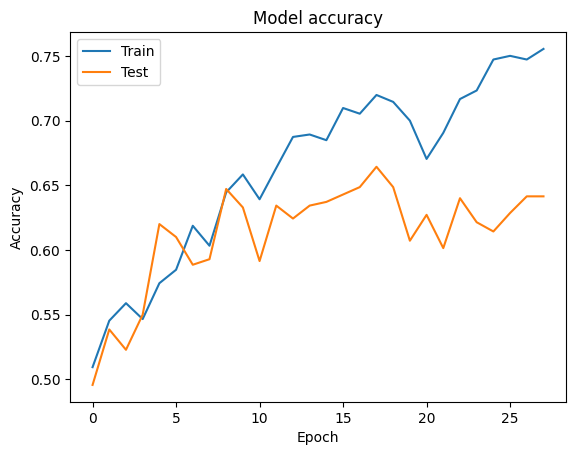

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate([X_test_ecg, X_test_pcg], y_test_segmented)
print(f"Test accuracy: {test_acc} , Test lost: {test_loss}")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()